In [1]:
import cv2 as cv
import numpy as np
from IPython.display import Image, display 
from matplotlib import pyplot as plt

In [2]:
def imshow(img, ax=None): 
    if ax is None: 
        ret, encoded = cv.imencode(".jpg", img) 
        display(Image(encoded)) 
    else: 
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) 
        ax.axis('off') 

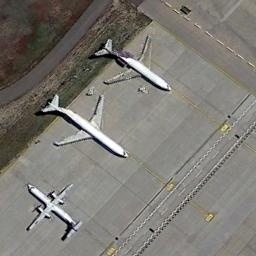

In [3]:
img = cv.imread('../datasets/NWPU-Captions/NWPU_images/airplane/airplane_621.jpg')
imshow(img)

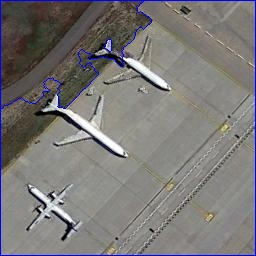

In [4]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]
imshow(img)

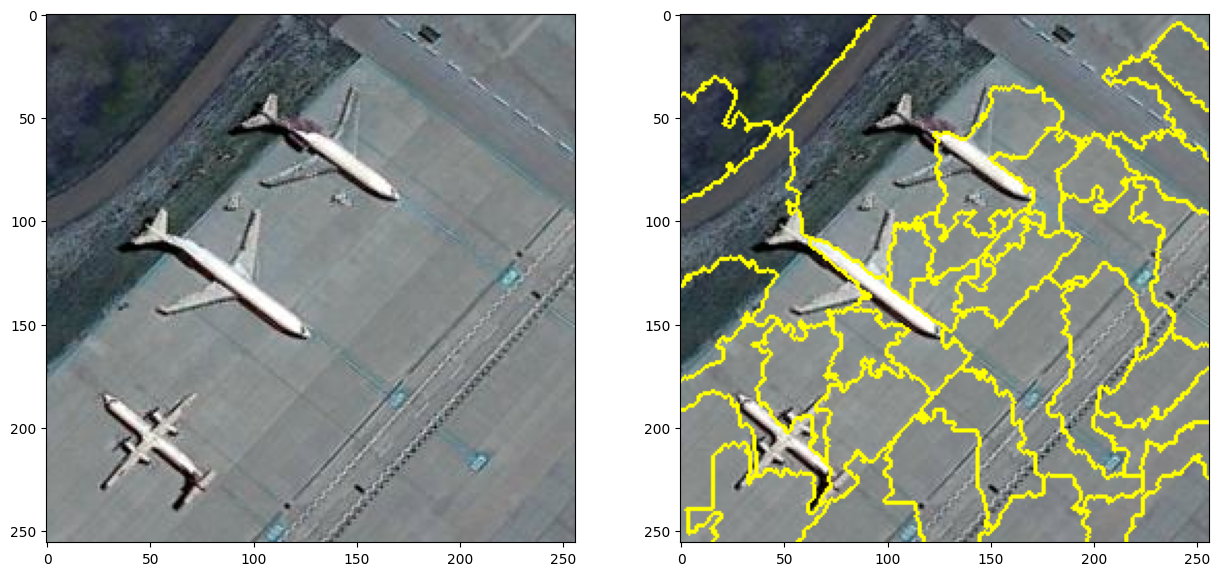

In [5]:

# Importing the required libraries
from skimage.segmentation import felzenszwalb
from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb
from skimage.data import astronaut
 
# Setting the figure size as 15, 15
plt.figure(figsize=(15,15))
 
# Sample Image of scikit-image package
astronaut = cv.imread('../datasets/NWPU-Captions/NWPU_images/airplane/airplane_621.jpg')
 
# computing the Felzenszwalb's
# Segmentation with sigma = 5 and minimum
# size = 100
astronaut_segments = slic(astronaut,
                          n_segments=100,
                          compactness=1)
 
# Plotting the original image
plt.subplot(1,2,1)
plt.imshow(astronaut)
 
# Marking the boundaries of
# Felzenszwalb's segmentations
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(astronaut,
                           astronaut_segments))

In [8]:
from skimage import segmentation, graph, io
img = io.imread('../datasets/NWPU-Captions/NWPU_images/airplane/airplane_621.jpg')
labels = segmentation.slic(img)
rag = graph.rag_mean_color(img, labels, mode='similarity')
new_labels = graph.cut_normalized(labels, rag)

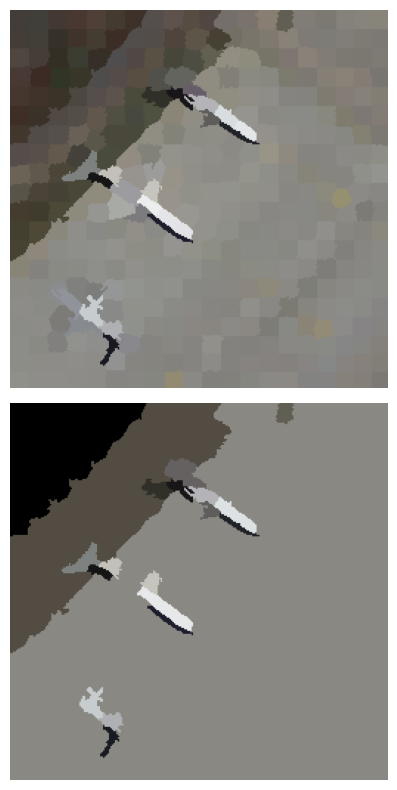

In [11]:
from skimage import io, segmentation, color
from skimage import graph
from matplotlib import pyplot as plt


img = io.imread('../datasets/NWPU-Captions/NWPU_images/airplane/airplane_621.jpg')

labels1 = segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 29)
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True,
                       figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

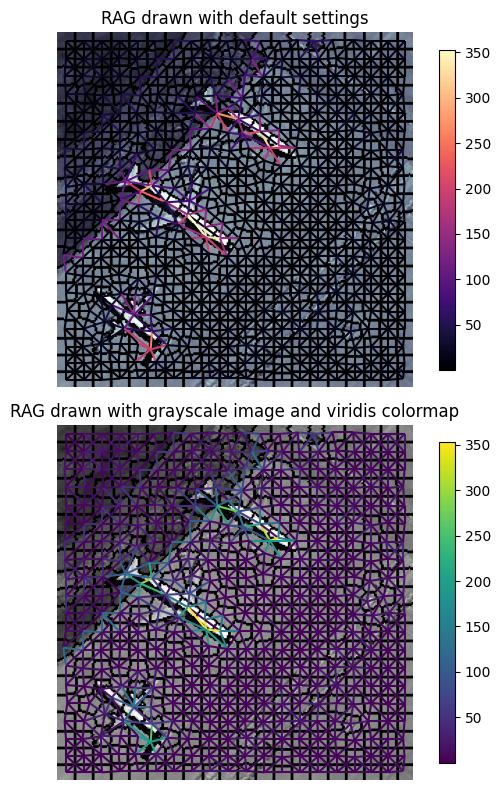

In [3]:
from skimage import data, segmentation, io
from skimage import graph
from matplotlib import pyplot as plt

img = io.imread('../datasets/NWPU-Captions/NWPU_images/airplane/airplane_621.jpg')
labels = segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
g = graph.rag_mean_color(img, labels)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].set_title('RAG drawn with default settings')
lc = graph.show_rag(labels, g, img, ax=ax[0])
# specify the fraction of the plot area that will be used to draw the colorbar
fig.colorbar(lc, fraction=0.03, ax=ax[0])

ax[1].set_title('RAG drawn with grayscale image and viridis colormap')
lc = graph.show_rag(labels, g, img,
                    img_cmap='gray', edge_cmap='viridis', ax=ax[1])
fig.colorbar(lc, fraction=0.03, ax=ax[1])

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

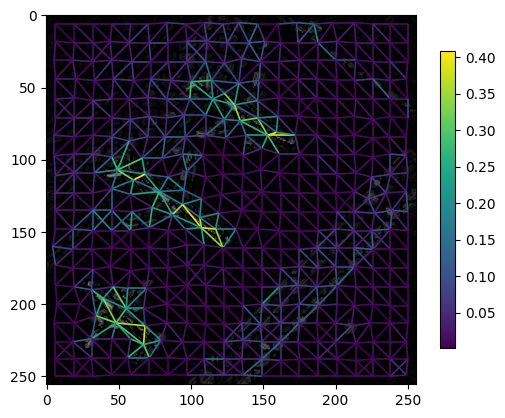

In [4]:
from skimage import graph
from skimage import data, segmentation, color, filters, io
from matplotlib import pyplot as plt


img = io.imread('../datasets/NWPU-Captions/NWPU_images/airplane/airplane_621.jpg')
gimg = color.rgb2gray(img)

labels = segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
edges = filters.sobel(gimg)
edges_rgb = color.gray2rgb(edges)

g = graph.rag_boundary(labels, edges)
lc = graph.show_rag(labels, g, edges_rgb, img_cmap=None, edge_cmap='viridis',
                    edge_width=1.2)

plt.colorbar(lc, fraction=0.03)
io.show()

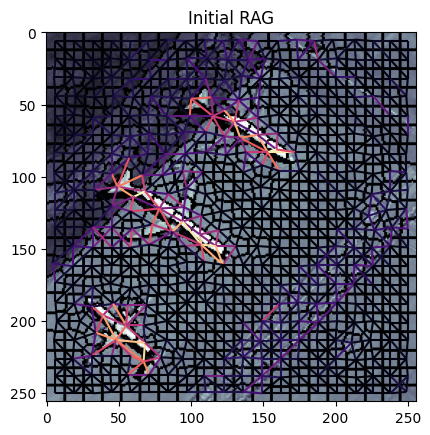

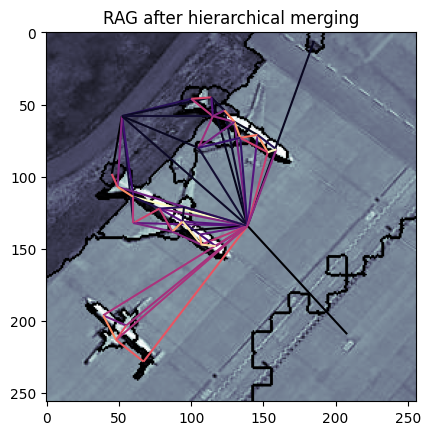

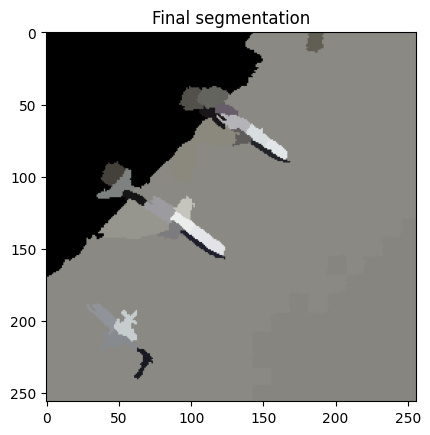

In [6]:
from skimage import data, segmentation, filters, color
from skimage import graph
from matplotlib import pyplot as plt


def weight_boundary(graph, src, dst, n):
    """
    Handle merging of nodes of a region boundary region adjacency graph.

    This function computes the `"weight"` and the count `"count"`
    attributes of the edge between `n` and the node formed after
    merging `src` and `dst`.


    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the "weight" and "count" attributes to be
        assigned for the merged node.

    """
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }


def merge_boundary(graph, src, dst):
    """Call back called before merging 2 nodes.

    In this case we don't need to do any computation here.
    """
    pass

img = io.imread('../datasets/NWPU-Captions/NWPU_images/airplane/airplane_621.jpg')
edges = filters.sobel(color.rgb2gray(img))
labels = segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
g = graph.rag_boundary(labels, edges)

graph.show_rag(labels, g, img)
plt.title('Initial RAG')

labels2 = graph.merge_hierarchical(labels, g, thresh=0.08, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

graph.show_rag(labels, g, img)
plt.title('RAG after hierarchical merging')

plt.figure()
out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
plt.imshow(out)
plt.title('Final segmentation')

plt.show()